1. Import Libraries and Set Configuration

In [ ]:
# Memory-Efficient Version for Task 2: Variety Classification
import os
import glob
import random
import cv2 as cv
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report  # Add F1 Score và classification_report

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
random.seed(45)

# Set Load Truncated Images to True
ImageFile.LOAD_TRUNCATED_IMAGES = True

2. Define Paths and Load Metadata

In [ ]:
# Setup Configuration and Constants
batch_size = 32  # Reduced batch size
img_height = 256
img_width = 256

# Define paths
HOME_PATH = os.getcwd() + "/"
TRAIN_IMG_PATH = HOME_PATH + 'train_images'
TEST_IMG_PATH = HOME_PATH + 'test_images'
META_TRAIN_PATH = HOME_PATH + 'meta_train.csv'
CHECKPOINT_MODEL_PATH = HOME_PATH + 'paddy_models/best_vit_variety_model.keras'
FINAL_MODEL_PATH = HOME_PATH + 'paddy_models/vit_variety_model.keras'
FINAL_WEIGHTS_PATH = HOME_PATH + 'paddy_models/vit_variety_weights.weights.h5'
# Create models directory if it doesn't exist
os.makedirs('paddy_models', exist_ok=True)

# Load metadata
print("Loading metadata...")
meta_train = pd.read_csv(META_TRAIN_PATH)

# Check unique varieties
unique_varieties = meta_train['variety'].unique()
num_varieties = len(unique_varieties)
print(f"Number of unique varieties: {num_varieties}")
print(f"Varieties: {unique_varieties}")

# Create variety label encoder
variety_encoder = LabelEncoder()
variety_labels = variety_encoder.fit_transform(meta_train['variety'])
variety_to_idx = {variety: idx for idx, variety in enumerate(variety_encoder.classes_)}

# Save label encoder for later use
import joblib
joblib.dump(variety_encoder, 'variety_label_encoder.joblib')

3. Create DataFrame and Split Data

In [ ]:
# Create a DataFrame with file paths and variety labels
def create_file_df(meta_df):
    """Create a DataFrame with file paths and variety indices"""
    data = []
    
    for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
        image_id = row['image_id']
        variety = row['variety']
        label = row['label']  # Disease label to find the folder
        
        # Construct image path
        img_path = os.path.join(TRAIN_IMG_PATH, label, image_id)
        
        if os.path.exists(img_path):
            data.append({
                'file_path': img_path,
                'variety_label': variety_to_idx[variety],
                'variety_name': variety,
                'image_id': image_id
            })
    
    return pd.DataFrame(data)

# Create file DataFrame
print("Creating file DataFrame...")
file_df = create_file_df(meta_train)
# Split data
train_df, val_df = train_test_split(
    file_df, test_size=0.3, random_state=42, stratify=file_df['variety_label']
)

4. Define Model Parameters and Create Datasets

In [ ]:
# Update parameters
num_classes = num_varieties
input_shape = (256, 256, 3)

# Configure the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
image_size = 72 
patch_size = 6 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]
# Create TensorFlow Dataset
def parse_image(file_path, label):
    """Parse image from file path"""
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def create_dataset(df, batch_size=32, is_training=True):
    """Create TensorFlow dataset from DataFrame"""
    file_paths = df['file_path'].values
    labels = df['variety_label'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.repeat()  # Repeat dataset for multiple epochs
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset
# Create datasets
train_dataset = create_dataset(train_df, batch_size=batch_size, is_training=True)
val_dataset = create_dataset(val_df, batch_size=batch_size, is_training=False)

# Calculate steps
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

5. Configure Data Augmentation and Normalization

In [ ]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Normalization layer (will be adapted during training)
normalization = layers.Normalization()

# Adapt normalization on a sample of data
sample_dataset = train_dataset.take(5)
normalization.adapt(sample_dataset.map(lambda x, y: x))

6. Define ViT Model Components

In [ ]:
# Multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implementing patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Implementing the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

7. Create Vision Transformer Model

In [ ]:
# ViT Model for Variety Classification
def create_vit_variety_classifier():
    inputs = layers.Input(shape=input_shape)
    # Normalize data
    normalized = normalization(inputs)
    # Augment data.
    augmented = data_augmentation(normalized)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes, activation='softmax', name='variety_output')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

8. Define F1 Score Callback

In [ ]:
# Create custom Callback for F1 Score
class F1ScoreCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, validation_steps):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.validation_steps = validation_steps
        self.val_f1_scores = []
        self.val_f1_scores_weighted = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Collect all predictions and real labels for validation
        y_true = []
        y_pred = []
        
        # Collect data form validation dataset
        for i in range(self.validation_steps):
            x_batch, y_batch = next(iter(self.validation_data))
            y_pred_batch = np.argmax(self.model.predict(x_batch), axis=1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(y_pred_batch)
        
        # F1 score
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        # Save to history
        self.val_f1_scores.append(f1_macro)
        self.val_f1_scores_weighted.append(f1_weighted)
        
        # Print F1 score
        print(f'\nEpoch {epoch+1}: val_f1_macro = {f1_macro:.4f}, val_f1_weighted = {f1_weighted:.4f}')
        
        # Add to logs for tracking
        logs['val_f1_macro'] = f1_macro
        logs['val_f1_weighted'] = f1_weighted

9. Define Training Callbacks and Model Training

In [ ]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_MODEL_PATH,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode='auto'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

# Model Setup and Training
def train_variety_model(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Create F1 score callback
    f1_callback = F1ScoreCallback(val_dataset, validation_steps)

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[checkpoint, reduce_lr, early_stopping, f1_callback],
        verbose=1
    )   
    
    # Add F1 score to history
    history.history['val_f1_macro'] = f1_callback.val_f1_scores
    history.history['val_f1_weighted'] = f1_callback.val_f1_scores_weighted

    return history

# Create and train model
vit_variety_classifier = create_vit_variety_classifier()
vit_variety_classifier.summary()
# Train the model
history = train_variety_model(vit_variety_classifier)

# Save model
vit_variety_classifier.save(FINAL_MODEL_PATH)
vit_variety_classifier.save_weights(FINAL_WEIGHTS_PATH)

10. Evaluate Model with F1 Score

In [ ]:
# Evaluate model for validation with F1 score
def evaluate_model_with_f1(model, val_dataset, val_steps):
    print("\nEvaluating model on validation set...")
    y_true = []
    y_pred = []
    
    # Pull predict labels and real labels
    for x_batch, y_batch in val_dataset.take(val_steps):
        y_pred_batch = np.argmax(model.predict(x_batch), axis=1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(y_pred_batch)
    
    # Evaluate metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=variety_encoder.classes_))
    
    # Calculate and print F1 Score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\nF1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    
    return f1_macro, f1_weighted

# Evaluate model after train
f1_macro, f1_weighted = evaluate_model_with_f1(vit_variety_classifier, val_dataset, validation_steps)

11. Plot Training Curves

In [ ]:
# Plot Learning Curves with F1 scores
def plot_training_curves(history):
    plt.figure(figsize=(18, 8))
    
    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot F1 Scores
    plt.subplot(2, 2, 3)
    plt.plot(history.history['val_f1_macro'], label='Validation F1 Macro')
    plt.title('Model F1 Score (Macro)')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_f1_weighted'], label='Validation F1 Weighted')
    plt.title('Model F1 Score (Weighted)')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves_with_f1.png')
    plt.show()

plot_training_curves(history)

12. Generate Test Predictions

Loading metadata...
Number of unique varieties: 10
Varieties: ['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR']
Creating file DataFrame...


100%|██████████| 10407/10407 [00:02<00:00, 3574.40it/s]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 72, 72, 3) │          0 │ normalization[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 108) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 144, 64)   │     16,192 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 144, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 144, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 144, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 144, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,666,769 (82.65 MB)

 Trainable params: 21,666,762 (82.65 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.5680 - loss: 2.5139
Epoch 1: val_accuracy improved from -inf to 0.69588, saving model to d:\COSC2753_A2_MachineLearning/paddy_models/best_vit_variety_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125m

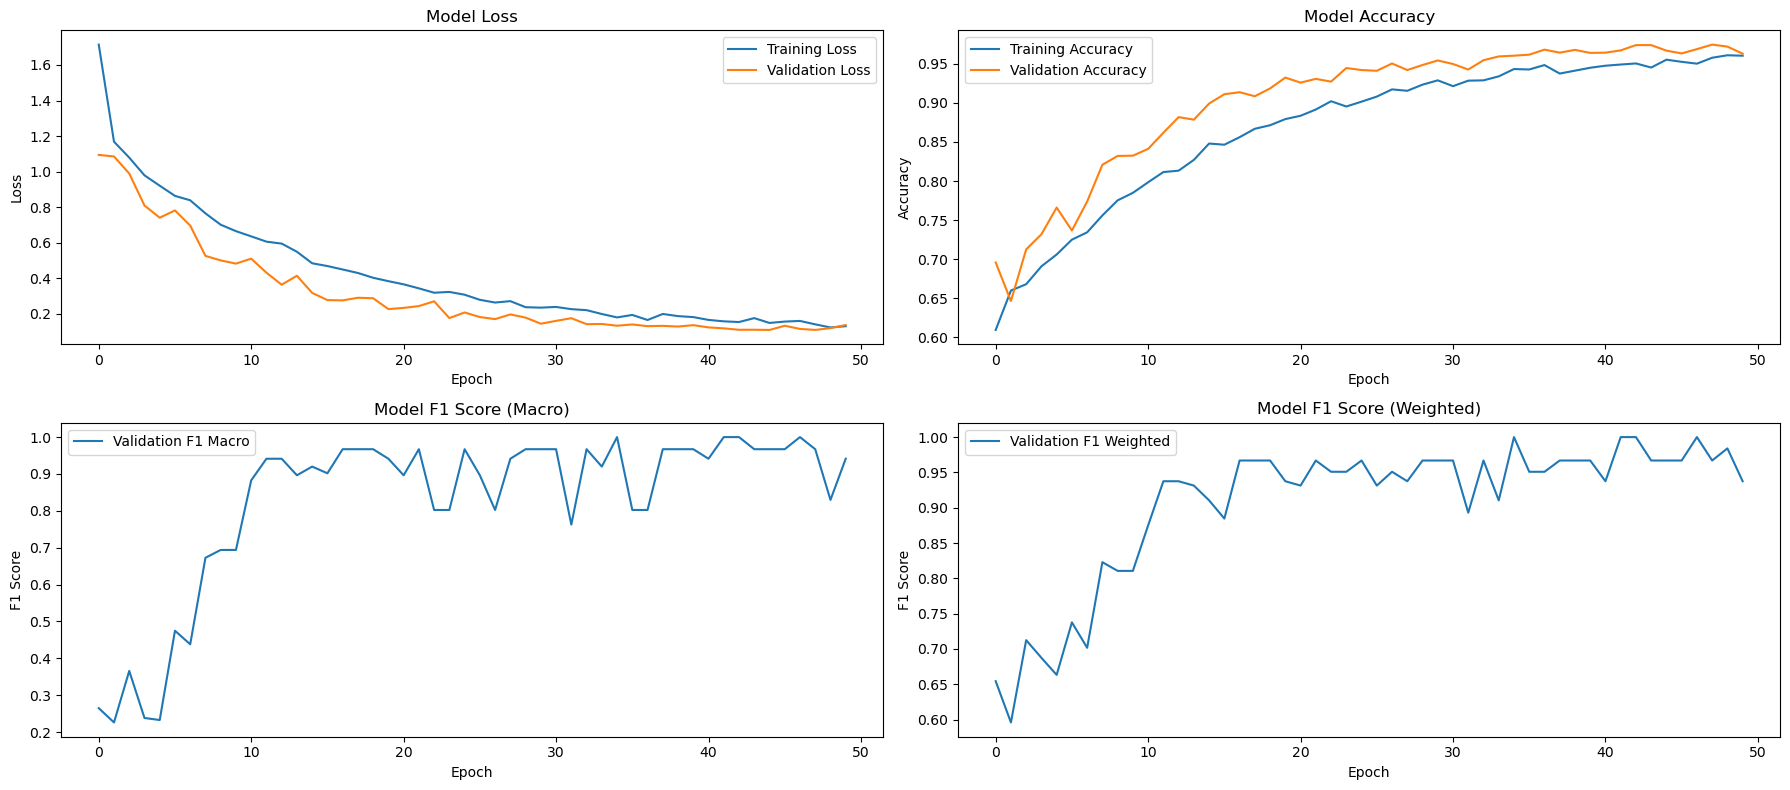

Creating test dataset...
Generating predictions...
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step
Predictions saved to 'variety_predictions_with_f1.csv'
Detailed predictions saved to 'variety_predictions_detailed_with_f1.csv'


In [ ]:
# Generate Predictions for Test Set
def create_test_dataset(test_path):
    """Create dataset for test images"""
    test_files = []
    test_ids = []
    
    for img_name in os.listdir(test_path):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(test_path, img_name)
            test_files.append(img_path)
            test_ids.append(img_name)
    
    # Create dataset without labels
    dataset = tf.data.Dataset.from_tensor_slices(test_files)
    dataset = dataset.map(lambda x: parse_image(x, 0)[0], num_parallel_calls=tf.data.AUTOTUNE)  # Only images, no labels
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, test_ids

# Create test dataset
print("Creating test dataset...")
test_pred_dataset, test_image_ids = create_test_dataset(TEST_IMG_PATH)

# Generate predictions
print("Generating predictions...")
predictions = vit_variety_classifier.predict(test_pred_dataset)
predicted_variety_indices = np.argmax(predictions, axis=1)
predicted_varieties = variety_encoder.inverse_transform(predicted_variety_indices)

# Create submission dataframe
submission_df = pd.DataFrame({
    'image_id': test_image_ids,
    'variety': predicted_varieties
})

# Save predictions
submission_df.to_csv('variety_predictions_with_f1.csv', index=False)
print("Predictions saved to 'variety_predictions_with_f1.csv'")

# Create a more detailed submission file
confidence_df = pd.DataFrame({
    'image_id': test_image_ids,
    'variety': predicted_varieties,
    'confidence': np.max(predictions, axis=1)
})

# Add top 3 predictions for each image
for i in range(3):
    top_n_indices = np.argsort(predictions, axis=1)[:, -(i+1)]
    confidence_df[f'variety_top_{i+1}'] = variety_encoder.inverse_transform(top_n_indices)
    confidence_df[f'confidence_top_{i+1}'] = np.sort(predictions, axis=1)[:, -(i+1)]

confidence_df.to_csv('variety_predictions_detailed_with_f1.csv', index=False)
print("Detailed predictions saved to 'variety_predictions_detailed_with_f1.csv'")